In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math


#Transmitter
#Generate Frames
def generate_shuffled_arrays(frame_size):
    original_array = np.pad(np.ones(frame_size//2), (0, frame_size//2)).astype(int)
    arrays = []
    for _ in range(1):
        shuffled_array = np.random.permutation(original_array)
        arrays.append(shuffled_array)
    return arrays

def generate_frame(frame_size, switch_graph):
    '''
        that means number of bits in total = 10*frame_size
    '''
    frame = []
    shuffled_arrays = generate_shuffled_arrays(frame_size)
    for arr in shuffled_arrays:
        frame.append(arr)
    return np.array(np.ravel(frame))        

In [2]:
#(7,4,3) Hamming code
#n:7, K:4 parity bits = 3
def encoded_hammingCode(signal):
    info = np.reshape(signal,(len(signal)//4,4)).astype(int)
    Identiy_matrix = np.identity(4).astype(int)
    parity_matrix = np.zeros((4,3))
    for i in range(len(Identiy_matrix)):
        parity_matrix[i][0] = ((Identiy_matrix[i][1] + Identiy_matrix[i][2] + Identiy_matrix[i][3])%2).astype(int)
        parity_matrix[i][1] = ((Identiy_matrix[i][0] + Identiy_matrix[i][2] + Identiy_matrix[i][3])%2).astype(int)
        parity_matrix[i][2] = ((Identiy_matrix[i][0] + Identiy_matrix[i][1] + Identiy_matrix[i][3])%2).astype(int)
    
    generator_matrix = np.concatenate((np.identity(4),parity_matrix),1).astype(int)
    parity_check_matrix =  np.concatenate(((-1*np.transpose(parity_matrix)),np.identity(3)),1).astype(int)
    
    condition1 = np.matmul(generator_matrix,np.transpose(parity_check_matrix))
    if(np.all(condition1 == 0)):
        codeword = np.matmul(info,generator_matrix) % 2
        codeword = np.array(codeword).astype(int)
        
        condition2 = np.matmul(codeword,np.transpose(parity_check_matrix))%2
        if(np.all(condition2 == 0)):
            return np.array(np.pad(np.array(np.squeeze(codeword).reshape(-1)).astype(int),(0,PADDING))).astype(int)
        else:
            raise Exception('codeword is wrong')
    else:
        raise Exception('generator and parity check matrix are wrong')
        #syndrome FEC decoding should be written

In [3]:
#(7,4,3) Hamming code
#n:7, K:4 parity bits = 3
#receiver Side
def forward_error_correction(syndrone_array,codeword):
    if(np.all(syndrone_array == np.array([1,0,0]))):
        return(np.array(np.array(codeword) ^ np.array([0,0,0,0,0,0,1])).astype(int))
    elif(np.all(syndrone_array == np.array([0,1,0]))):
        return(np.array(np.array(codeword) ^ np.array([0,0,0,0,0,1,0])).astype(int))
    elif(np.all(syndrone_array == np.array([1,1,1]))):
        return(np.array(np.array(codeword) ^ np.array([1,0,0,0,0,0,0])).astype(int))
    elif(np.all(syndrone_array == np.array([0,0,1]))):
        return(np.array(np.array(codeword) ^ np.array([0,0,0,0,1,0,0])).astype(int))
    elif(np.all(syndrone_array == np.array([1,0,1]))):
        return(np.array(np.array(codeword) ^ np.array([0,1,0,0,0,0,0])).astype(int))
    elif(np.all(syndrone_array == np.array([0,1,1]))):
        return(np.array(np.array(codeword) ^ np.array([0,0,1,0,0,0,0])).astype(int))
    elif(np.all(syndrone_array == np.array([1,1,1]))):
        return(np.array(np.array(codeword) ^ np.array([0,0,0,1,0,0,0])).astype(int))
    else:
        return(np.array(codeword).astype(int))
            
def decoded_hammingCode(signal):
    signal = np.array(signal[:len(signal) - PADDING]).astype(int)
    Identiy_matrix = np.identity(4).astype(int)
    parity_matrix = np.zeros((4,3))
    sink = []
    corrected_codeword = []

    code_matrix = np.reshape(signal,(len(signal)//7,7))
    for i in range(len(Identiy_matrix)):
        parity_matrix[i][0] = ((Identiy_matrix[i][1] + Identiy_matrix[i][2] + Identiy_matrix[i][3])%2).astype(int)
        parity_matrix[i][1] = ((Identiy_matrix[i][0] + Identiy_matrix[i][2] + Identiy_matrix[i][3])%2).astype(int)
        parity_matrix[i][2] = ((Identiy_matrix[i][0] + Identiy_matrix[i][1] + Identiy_matrix[i][3])%2).astype(int)
    parity_matrix = np.array(parity_matrix).astype(int)
    linear_parity_matrix = np.array(np.concatenate((np.transpose(parity_matrix),np.identity(3)),1)).astype(int)
    
    syndrome_signal = np.matmul(code_matrix,np.transpose(linear_parity_matrix)) % 2
    
    for i,syn_data in enumerate(syndrome_signal):
        corrected_codeword.append(forward_error_correction(syn_data,code_matrix[i]))
        
    for _,data in enumerate(corrected_codeword):
        sink.append(data[:4])
    return np.array(np.ravel(sink).astype(int))               

In [4]:
def BinaryToGray(data):
    signal = []
    for i in range(0, len(data)):
        if i == 0:
            signal.append(data[i])
        else:
            signal.append(data[i] ^ data[i-1])
    return np.array(signal).astype(int)


def GrayToBinary(data):
    binary_code = []
    binary_code.append(data[0])  # Add the first element as is
    for i in range(1, len(data)):
        binary_code.append(binary_code[i-1] ^ data[i])  # Perform XOR operation
    return np.array(binary_code).astype(int)



In [5]:
def qam_modulation(gray_code):
    qam_signal = QAM_SIGNAL
    qam_values = QAM_VALUES
    #qam_signal = np.array(qam_signal).astype(int)
    #qam_values = np.array(np.divide(qam_values,np.max(np.sqrt(qam_values)))).astype(complex)
    binary_code = np.reshape(gray_code,(len(gray_code)//den,den)).astype(int)
    
    mapping = []
    for _,data in enumerate(binary_code):
        for i,data_point in enumerate(qam_signal):
            if(np.all(data == data_point)):
                mapping.append(qam_values[i])
    mapping = np.array(mapping).astype(complex)
    
    
    #normalized_signal = np.array(np.divide(mapping,np.max(np.sqrt(mapping)))).astype(complex)
    
    if switch_graph:
        plt.figure()
        plt.plot(np.real(qam_values),np.imag(qam_values),"ro")
        plt.title("QAM modulation - IQ plot")
        plt.grid(True)
        plt.show()
    #return normalized_signal
    return mapping

In [6]:
def qam_demodulation(modulation):
    qam_signal = QAM_SIGNAL
    qam_values = QAM_VALUES
    #qam_signal = np.array(qam_signal).astype(int)
    #qam_values = np.array(np.divide(qam_values,np.max(np.sqrt(qam_values)))).astype(complex)

    #demapping
    #distances = np.abs(np.expand_dims(modulation, axis=1) - np.divide(qam_values,np.max(np.abs(qam_values))))
    distances = np.abs(np.expand_dims(modulation, axis=1) - qam_values)
    demodulated_indices = np.argmin(distances, axis=1)
    demodulated_indices = np.array(demodulated_indices)
  
    demodulated_values = []
    for i in range(len(demodulated_indices)):
        index = demodulated_indices[i]
        demodulated_values.append(qam_signal[index])
    demodulated_values = np.array(np.squeeze(demodulated_values).reshape(-1),dtype=int)
    
    if switch_graph:
        plt.figure()
        plt.plot(np.real(qam_values),np.imag(qam_values),"ro")
        plt.plot(np.real(modulation),np.imag(modulation),"b*")
        plt.title("QAM Demodulation - IQ plot")
        plt.axhline(0, color='red')
        plt.axvline(0, color='blue')
        plt.grid(True)
        plt.show()
    return demodulated_values

In [7]:
def simulate_channel(modulation,SNR_db):
    SNR_Lin = np.power(10,SNR_db/10)
    noise = (1/np.sqrt(QAM_MAX))*(np.random.randn(1,len(modulation))+(1j*np.random.randn(1,len(modulation))))
    std=np.sqrt(1/((np.log2(MODULATION))*SNR_Lin))
    y_volts = modulation + std*noise
    signal = np.squeeze(y_volts).reshape(-1)
    return signal

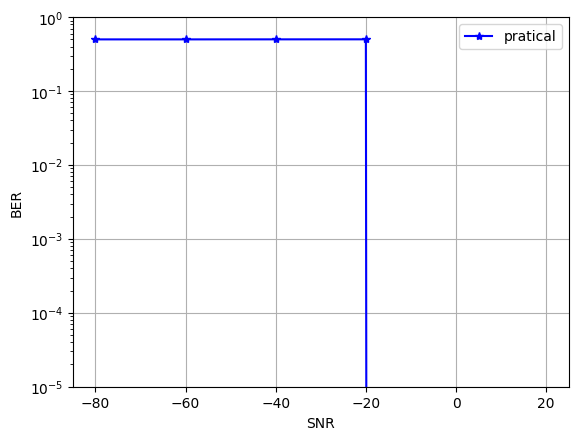

In [8]:
if __name__ == "__main__":
    switch_graph = 0
    numer_of_bits = int(np.power(2,20))
    MODULATION = 16
    SNR_dbs = np.arange(-80,40,20)
    EN_Channel_coding = 1
    
    #4_QAM
    if MODULATION == 4:
        QAM_SIGNAL = [[0,0],[1,0],[0,1],[1,1]]
        QAM_VALUES = [-1 -1j,1 -1j,-1 +1j,1 +1j]
        QAM_MAX = 2
        den = (int)(np.log2(MODULATION))
        PADDING = 0
    #16_QAM
    elif MODULATION == 16:
        QAM_SIGNAL = [[0,0,0,0],[1,0,0,0],[0,1,0,0],[1,1,0,0],[0,0,1,0],[1,0,1,0],[0,1,1,0],[1,1,1,0],[0,0,0,1],[1,0,0,1],[0,1,0,1],[1,1,0,1],[0,0,1,1],[1,0,1,1],[0,1,1,1],[1,1,1,1]]
        QAM_VALUES = [-3 +3j,-3+1j,-3-3j,-3-1j,-1 +3j, -1+1j ,-1-3j , -1-1j, +3 +3j, +3+1j ,+3-3j , +3-1j,+1 +3j, +1+1j ,+1-3j , +1-1j]
        QAM_MAX = 18
        PADDING = 16
        den = (int)(np.log2(MODULATION))
    
    '''
    Enabled Channel coding(Coded)
    '''
    signal = generate_frame(numer_of_bits,0)
    if EN_Channel_coding:
        encoded_signal = encoded_hammingCode(signal)
    else:
        encoded_signal = signal
    gray_code = BinaryToGray(encoded_signal)
    modulation = qam_modulation(gray_code)    
    BER = []
    for _,SNR_db in enumerate(SNR_dbs):
        channel_signal = simulate_channel(modulation,SNR_db)
        de_modulation = qam_demodulation(channel_signal)
        binary_code = GrayToBinary(de_modulation)
        if EN_Channel_coding:
            sink = decoded_hammingCode(binary_code)
        else:
            sink = binary_code
        BER.append(np.mean(signal ^ sink))    

    
    plt.figure()
    plt.semilogy(SNR_dbs,BER,'b*-')
    plt.legend(['pratical'])
    plt.xlabel('SNR')
    plt.ylabel('BER')
    plt.grid(True)
    plt.ylim([10e-6,0.9999999999])
    plt.show()
     